# Preprocessinng

In [217]:
#!pip install xgboost
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("training_data.csv")
df.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...


## Pre-processing

pre-process the sessions (you can execute these tasks in the order you prefer, but make sure to specify which task is being solved in which block of code):
1. sessionise <font color='red'>(1pt)</font>
1. select sessions with at least one add-to-cart <font color='red'>(1pt)</font>
1. add class labels: treat purchase as the positive class <font color='red'>(1pt)</font>
1. cut purchase sessions to the last event before the first purchase <font color='red'>(1pt)</font>
1. remove sessions shorter than 5 and longer than 155 clicks <font color='red'>(1pt)</font>
1. symbolise actions <font color='red'>(1pt)</font>


In [3]:
# Sessionise:
# derive sessions from action by action dataset
# merge all the actions by session_id

df['product_action'] = df['product_action'].fillna('view')
df = df.groupby('session_id_hash')['product_action'].agg(list).reset_index()
df.head()

,session_id_hash,product_action
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi..."
1,000009f36a40de1d557afc083dbb3fc03eef2473337bad...,"[view, view]"
2,00000e812c3076d18245710a31b348d3f23314b7d0dc90...,[view]
3,00001355930ff05e66ab30bccff221c33eba90e1517397...,"[view, detail]"
4,0000162d1dad0beb867c191ab2c8c7c06086cc57d9ebe2...,"[view, view, view, view, detail, view, detail,..."


In [4]:
##  labelization
df['purchase'] = np.where(df.product_action.map(set(['purchase']).issubset), 1, 0)
df.head()

,session_id_hash,product_action,purchase
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0
1,000009f36a40de1d557afc083dbb3fc03eef2473337bad...,"[view, view]",0
2,00000e812c3076d18245710a31b348d3f23314b7d0dc90...,[view],0
3,00001355930ff05e66ab30bccff221c33eba90e1517397...,"[view, detail]",0
4,0000162d1dad0beb867c191ab2c8c7c06086cc57d9ebe2...,"[view, view, view, view, detail, view, detail,...",0


In [5]:
### Cut actions before purchase if there is one
### keep the full sesssion if there is not
df['product_action'] = df['product_action'].map(lambda x: x[0:x.index('purchase')] if 'purchase' in x else x)

## select sessions with at least one add-to-cart
df = df[df.product_action.map(lambda x: "add" in x)]

### Filtered out outliers which > 155 or < 5.    

df["len"] = df["product_action"].map(len)

# removing very short and very long sessions
df.drop(df[df.len < 5].index, inplace=True)
df.drop(df[df.len > 155].index, inplace=True)

df.head()

,session_id_hash,product_action,purchase,len
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0,18
37,0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...,"[view, view, view, detail, view, view, detail,...",0,139
64,00010d84aca1294479304044207fd268f63228844779c6...,"[view, view, view, detail, view, view, view, v...",0,41
84,0001368d732951035a7ef7ef42b345a5c50b7d66966749...,"[view, detail, add, view, view, detail, add, v...",0,16
119,0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...,"[view, view, view, view, detail, add, remove, ...",1,29


In [6]:
## Sanity check: the output should be True
df[df.product_action.map(lambda x: "add" not in x)].shape[0]

0

In [6]:
## symbolise actions

from collections import Counter

sessions = df['product_action'].to_list()
labels = df['purchase'].to_list()

counts = Counter([item for session in sessions for item in session])
symbol2idx = {symbol: idx for idx, symbol in enumerate(sorted(counts, key=counts.get, reverse=True), 1)}

df["session"]=df["product_action"].map(lambda session: [symbol2idx[s] for s in session])

df.head()

,session_id_hash,product_action,purchase,len,session
0,00000114e1075962f022114fcfc17f2d874e694ac5d201...,"[view, detail, add, view, view, view, view, vi...",0,18,"[1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ..."
37,0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...,"[view, view, view, detail, view, view, detail,...",0,139,"[1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ..."
64,00010d84aca1294479304044207fd268f63228844779c6...,"[view, view, view, detail, view, view, view, v...",0,41,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ..."
84,0001368d732951035a7ef7ef42b345a5c50b7d66966749...,"[view, detail, add, view, view, detail, add, v...",0,16,"[1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
119,0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...,"[view, view, view, view, detail, add, remove, ...",1,29,"[1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 4, 4, 4, ..."


In [7]:
## Check the symbolisation
symbol2idx

{'view': 1, 'detail': 2, 'add': 3, 'remove': 4}

## Oracle model

In [66]:
def oracle(X_train, y_train):
    '''
    This function return a oracle model based on the session and label.
    '''
    from collections import defaultdict

    d = defaultdict(lambda: defaultdict(int))
    for s, l in zip(X_train, y_train):
        d[str(tuple(s))][l] += 1
        
    model = {}
    for session in d.keys():
        n_buy, n_ws = 0, 0
        for label in d[session].keys():
            if label:
                n_buy += d[session][label]
            else:
                n_ws += d[session][label]
        model[session] = n_buy / (n_buy + n_ws)
        
    return model

def oracle_predict(model, X_test, y_test=None):
    '''
    1. Make prediction on X_test.
    2. For possibility >0.5 predict 1, else 0.
    3. reutrn prediction and F1 score
    '''
    from sklearn import metrics

    y_pred = []
    for x in X_test:
        pos = model.get(str(x), "#") ## For sessions that not in the model, we assign it to #, and then predict 0.
        y_pred.append(pos)
        
    ## count "#" first and substitute with 0
    missing_rate = y_pred.count("#")/len(y_pred)

    y_pred = [1 if y != "#" and y >= 0.5 else 0 for y in y_pred]
        
    if y_test is not None:
#         y_test = y_test.to_list()
        f1 = metrics.f1_score(y_test, y_pred)
        return(f1, missing_rate,y_pred)
    else:
        return y_pred

In [67]:
## Oracle model for 5 clicks
## Subset from the original df
from sklearn.model_selection import train_test_split

i = 5
data = df[["session", "purchase"]]
data.session = df.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = df.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.8457940701701135

In [68]:
# oracle model for 10 clicks
i = 10
data = df[["session", "purchase"]]
data.session = df.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = df.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.8457940701701135

In [69]:
# oracle model for 15 clicks
i = 15
data = df[["session", "purchase"]]
data.session = df.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
data.session = df.session.map(tuple)
data = data.dropna()
    
model = oracle(data.session, data.purchase)
f1, missing_rate, prediction = oracle_predict(model, data.session, data.purchase)
f1

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.8457940701701135

## Hold Out

1. Subset data for n-click (n=5, 10, 15) models.
1. Do train/test split in for each subset.

In [8]:
### get subset for training
## make the prediction for 5, 10 and 15, and store the f1 it in a dict
## First split the train/test data
from sklearn.model_selection import train_test_split
from collections import defaultdict

data = defaultdict(lambda: defaultdict())

for i in [5, 10, 15]:
    
    ## Subset from the original df
    temp = df[["session", "purchase"]]
    temp.session = temp.session.map(lambda x: x[:x.index(3)+1+i] if len(x[x.index(3)+1:])>=i else None)
    temp = temp.dropna()
    
    ## Split train and test
    X_train, X_test, y_train, y_test = train_test_split(temp["session"], temp["purchase"], test_size=0.2, random_state=123)
    data[f"{i}_clicks"]["X_train"] = X_train.to_numpy()
    data[f"{i}_clicks"]["X_test"] = X_test.to_numpy()
    data[f"{i}_clicks"]["y_train"] = y_train.to_numpy()
    data[f"{i}_clicks"]["y_test"] = y_test.to_numpy()

In [9]:
data_size = pd.DataFrame(data).applymap(len)
data_size

,5_clicks,10_clicks,15_clicks
X_train,86213,60709,44216
X_test,21554,15178,11054
y_train,86213,60709,44216
y_test,21554,15178,11054


## Naive Bayes Model

In [18]:
def ngram_featurizer(session, n=3):
    
    """takes in a list and an integer defining the size of ngrams.
     Returns the ngrams of desired size in the input string"""
    
    session = ['#']*(n-1) + session + ['+']*(n-1)
    ngrams = [tuple(session[i:i+n]) for i in range(len(session)-n+1)]
    
    return ngrams
    

def encode_sessions(sessions,n=3, mapping=None):
    
    """
    Takes in a list of lists, an integer indicating the character ngrams' size,
    and a dictionary mapping ngrams to numerical indices. If no dictionary is passed,
    one is created inside the function.
    The function outputs a 2d NumPy array with as many rows as there are strings in 
    the input list, and the mapping from ngrams to indices, representing the columns 
    of the NumPy array.
    """
    
    if not mapping:
        all_ngrams = set()
        for session in sessions:
            all_ngrams = all_ngrams.union(set(ngram_featurizer(session, n)))
    
        mapping = {ngram: i for i, ngram in enumerate(all_ngrams)}
    
    X = np.zeros((len(sessions), len(mapping)))
    for i, session in enumerate(sessions):
        for ngram in ngram_featurizer(session, n):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    
    return X, mapping

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

score = {}
for i in [5,10,15]:
    sessions_train = data[f"{i}_clicks"]["X_train"]
    sessions_eval = data[f"{i}_clicks"]["X_test"]
    labels_train = data[f"{i}_clicks"]["y_train"]
    labels_eval = data[f"{i}_clicks"]["y_test"]

    Xtrain, mapping = encode_sessions(sessions_train)
    Xtest, _ = encode_sessions(sessions_eval, mapping=mapping)

    NB = MultinomialNB(alpha=1, fit_prior=True)
    NB.fit(Xtrain,labels_train)
    bayes_predictions = NB.predict(Xtest)
    
    f1 = metrics.f1_score(labels_eval, bayes_predictions)
    
    score[f"F1_{i}-clicks"] = f1

In [34]:
score

{'F1_5-clicks': 0.34254807692307687,
 'F1_10-clicks': 0.3847316704459562,
 'F1_15-clicks': 0.3973732951675366}

## Advanced Model: XGBoost Classifier

### 5-clicks

#### Featurization & Downsampling

In [218]:
### Get the copy of the data
i = '5_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

#### Model Train and Predict

In [219]:
## ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#        {'gamma': 0, 
#         'learning_rate': 0.05, 
#         'max_depth': 5, 
#         'reg_lambda': 10.0, 
#         'scale_pos_weight': 1}

## Round 2
param_grid = {
        'gamma': [0], 
        'learning_rate': [0.05], 
        'max_depth': [5, 6, 7],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [1]}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 11.0, 'scale_pos_weight': 1}


In [220]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.42948676461070484

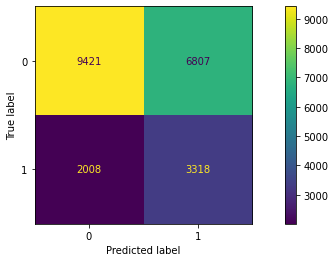

In [221]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

### 10-clicks

#### Featurization & Downsampling

In [222]:
### Get the copy of the data
i = '10_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

#### Model Train and Predict

In [226]:
# ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#        {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}

## Round 2
param_grid = {
        'gamma': [1], 
        'learning_rate': [0.1], 
        'max_depth': [4],
        'reg_lambda': [9.0, 10.0, 11.0],
        'scale_pos_weight': [3]}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [227]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.41459776238678736

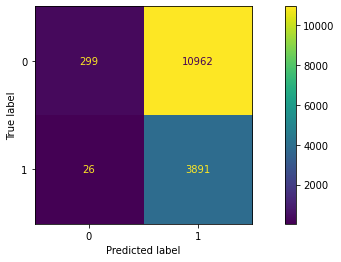

In [228]:
## Plot the confusion metrics
plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')

### 15-clicks

#### Featurization & Downsampling

In [229]:
### Get the copy of the data
i = '15_clicks'
X_train = data[i]['X_train']
y_train = data[i]['y_train']
X_test = data[i]['X_test']
y_test = data[i]['y_test']

### Downsampling the training data
### And keep the test data in shape
temp = pd.DataFrame({"session": X_train, 'purchase': y_train})

class_0 = temp[temp.purchase == 0]
class_1 = temp[temp.purchase == 1]

class_0 = resample(class_0,
             replace=True,
             n_samples=len(class_1),
             random_state=123)


data_downsampled = pd.concat([class_0, class_1])

X_train = data_downsampled.session
y_train = data_downsampled.purchase

### Featurization
## Doing ngrams with n = 1 AND 2

one_gram, maping_1 = encode_sessions(X_train,n=1, mapping=None)
two_gram, maping_2 = encode_sessions(X_train,n=2, mapping=None)

maping_2 = {key: value + len(maping_1) for key,value in maping_2.items()}
maping = {**maping_1, **maping_2}
X_train = np.concatenate((one_gram, two_gram), axis=1)

# featurize X_test
X = np.zeros((len(X_test), len(maping)))
for i, session in enumerate(X_test):
    for ngram in ngram_featurizer(session, 1) + ngram_featurizer(session, 2):
        try:
            X[i, maping[ngram]] += 1
        except KeyError:
            pass
X_test = X

#### Model Train and Predict

In [231]:
## ROUND 1
# param_grid = {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,3,5]
# }

# RESULT of the first Round:
#       {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}

## Round 2
# param_grid = {
#         'gamma': [0.25], 
#         'learning_rate': [0.1], 
#         'max_depth': [5, 6, 7],
#         'reg_lambda': [9.0, 10.0, 11.0],
#         'scale_pos_weight': [3]}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=123,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='f1',
    verbose = 0,
    n_jobs = 5,
    cv = 3
)

optimal_params.fit(X_train,
                   y_train,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(X_test, y_test)],
                  verbose=False)
print(optimal_params.best_params_)

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/moyang/.pyenv/v

/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/moyang/.pyenv/versions/3.8.12/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/moyang/.pyenv/v

KeyboardInterrupt: 

In [220]:
## Fit and Predict
preds = optimal_params.predict(X_test)

f1 = metrics.f1_score(y_test, preds)

f1

0.42948676461070484

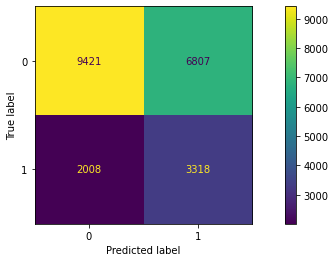

In [221]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(optimal_params,
                      X_test,
                      y_test,
                      values_format='d')